In [27]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.2.0

In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

In [30]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]
print('numFeatures is : ', numFeatures )
# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]
print('numLabels is : ', numLabels )

X = tf.Variable( np.identity(numFeatures), tf.TensorShape(numFeatures),dtype='float32') # Iris has 4 features, so X is a tensor to hold our data.
yGold = tf.Variable(np.array([1,1,1]),shape=tf.TensorShape(numLabels),dtype='float32') # This will be our correct answers matrix for 3 classes.

numFeatures is :  4
numLabels is :  3


In [31]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [32]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random.normal([numFeatures,numLabels],
                                       mean=0.,
                                       stddev=0.01,
                                       name="weights"),dtype='float32')


bias = tf.Variable(tf.random.normal([1,numLabels],
                                    mean=0.,
                                    stddev=0.01,
                                    name="bias"))

In [33]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
def logistic_regression(x):
    apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
    add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
    activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")
    return activation_OP

In [34]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0008,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [35]:
#Defining our cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learningRate)

In [39]:
# Accuracy metric.
def accuracy(y_pred, y_true):
# Predicted class is the index of the highest score in prediction vector (i.e. argmax).
    print('y_pred : ',y_pred)
    print('y_true : ',y_true)
    correct_prediction = tf.equal(tf.argmax(y_pred, -1), tf.argmax(y_true, -1))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
# Optimization process. 

def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = loss_object(pred, y)
    gradients = g.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

In [40]:
# Initialize reporting variables
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1
# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .000001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        run_optimization(X, yGold)
        
        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            
            pred = logistic_regression(X)

            newLoss = loss_object(pred, yGold)
            # Add loss to live graphing variable
            loss_values.append(newLoss)
            
            # Generate accuracy stats on test data
            acc = accuracy(pred, yGold)
            accuracy_values.append(acc)
            
    
            # Re-assign values for variables
            diff = abs(newLoss - loss)
            loss = newLoss

            #generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, newLoss, diff))

        

          

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(acc))


y_pred :  tf.Tensor(
[[0.5008607  0.49619627 0.5031397 ]
 [0.49938205 0.5000557  0.50324625]
 [0.50528294 0.502026   0.5006011 ]
 [0.4982811  0.5065595  0.49489543]], shape=(4, 3), dtype=float32)
y_true :  <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>
step 0, training accuracy 0.25, loss 0.0824312, change in loss 0.0824312
y_pred :  tf.Tensor(
[[0.5009404  0.49627614 0.5032193 ]
 [0.4994618  0.5001353  0.50332594]
 [0.5053624  0.5021056  0.5006809 ]
 [0.4983609  0.50663877 0.49497548]], shape=(4, 3), dtype=float32)
y_true :  <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>
step 10, training accuracy 0.25, loss 0.0824007, change in loss 3.04729e-05
y_pred :  tf.Tensor(
[[0.5010201  0.49635595 0.50329894]
 [0.49954155 0.500215   0.5034056 ]
 [0.50544184 0.5021851  0.5007607 ]
 [0.49844068 0.5067181  0.49505547]], shape=(4, 3), dtype=float32)
y_true :  <tf.Variable 'Variable:0' shape=(3,) dtype=fl

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


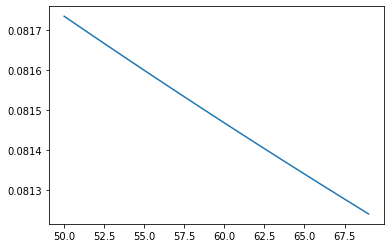

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i-50:i]) for i in range(len(loss_values))])
plt.show()